In [1]:
# -------------------- Model 2: Model 1 + LoRA on SubCorpus --------------------
import pandas as pd
import os
import math
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, get_cosine_schedule_with_warmup
import matplotlib.pyplot as plt
from torch.optim import AdamW
import torch.nn.functional as F
from peft import LoraConfig, get_peft_model, TaskType
import gc
import unicodedata
from collections import Counter
import time

# Runtime configuration
EVAL_EVERY = 4 # Fixed interval for full-gallery evaluation
use_amp = torch.backends.mps.is_available() # Enable AMP only on MPS devices
amp_dtype = torch.float16

# Set seed for reproducibility
random.seed(985)
np.random.seed(985)
torch.manual_seed(985)

# Load the datasets
m2_train = pd.read_csv("/Users/cyq/Desktop/Dissertation/Database/SubCorpus_to_train.csv")
m2_val = pd.read_csv("/Users/cyq/Desktop/Dissertation/Database/SubCorpus_to_validation.csv")

# Load the base model with its processor
base_model = "/Users/cyq/Desktop/Dissertation/Database/m1_clip_trained/final_model"
processor = CLIPProcessor.from_pretrained(base_model, use_fast = False)
model = CLIPModel.from_pretrained(base_model)

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device.type}")
model.to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parameters size: total = {total_params / 1e6:.2f}M, trainable = {trainable_params / 1e6:.2f}M")

# Define a dataset for Model 2
class ArtEmisDataset(Dataset):
    # Intialise the dataframe and CLIP precessor
    def __init__(self, df, processor): 
        self.data = df.reset_index(drop = True)
        self.processor = processor
        self.valid_idx = [i for i in range(len(self.data))
                          if os.path.exists(str(self.data.iloc[i]["PATH"]))]
    # Extract samples by rows
    def __getitem__(self, idx):
        ridx = self.valid_idx[idx]
        row = self.data.iloc[ridx] # Select the ith row from the dataframe
        path = row["PATH"] # Find the path
        text = str(row["UTTERANCE"]) if not pd.isna(row["UTTERANCE"]) else "" # Find the paired description
        # Try to open the image
        try:
            img = Image.open(path).convert("RGB")
        except Exception:
            img = Image.new("RGB", (224, 224), "white")
            print(f"Warning: Failed to load {path}, using white image")
        # Preprocess both text and image
        inputs = self.processor(text = [text], 
                                images = img, 
                                return_tensors = "pt",
                                padding = "max_length", 
                                truncation = True, 
                                max_length = 77)
        # Return a dictionary contains input_ids, attention_mask and pixel_values
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "pixel_values": inputs["pixel_values"].squeeze(0)
        }
    # Compute the length of dataset
    def __len__(self):
        return len(self.valid_idx)
     

# Define a function to evaluate model performance by using full-gallery retrieval
@torch.no_grad()
def evaluate_full_gallery(model, val_loader, device, topk = (1, 5, 10), chunk = 256):
    # Set the model to evaluation mode
    model.eval()
    # Create empty lists to contain all images and texts
    all_img = []
    all_txt = []
    # Loop through the validation dataloader to extract features
    for b in val_loader:
        ids = b["input_ids"].to(device)
        attn = b["attention_mask"].to(device)
        pix = b["pixel_values"].to(device)
        # Extract CLIP image and text features
        img = model.get_image_features(pix)
        txt = model.get_text_features(input_ids = ids, attention_mask = attn)
        # Normalize embeddings to unit length
        img = img / img.norm(p = 2, dim = -1, keepdim = True)
        txt = txt / txt.norm(p = 2, dim = -1, keepdim = True)
        # Add them into lists separatelt
        all_img.append(img)
        all_txt.append(txt)
    # Combine all batches into single tensors
    all_img = torch.cat(all_img, 0)
    all_txt = torch.cat(all_txt, 0)
    # Set N as the number of validation samples
    N = all_txt.size(0)
    # Get the learned logit scale
    logit_scale = model.logit_scale.exp().clamp_max(100.0)
    # Prepare to count Recall@K metrics
    max_k = max(topk)
    hits = {k:0 for k in topk} # Count of correct matches for each K
    ranks_list = [] # Create an empty list to contain the ground truth's rank position
    # Compute similarity
    for i in range(0, N, chunk):
        i_end = min(i + chunk, N)
        sims = logit_scale * (all_txt[i:i_end]@all_img.T) # Similarity matrix
        # Get the indices of top-k most similar images
        topk_idx = sims.topk(k = max_k, dim = 1).indices
        # Ground truth indices
        gt = torch.arange(i, i_end, device = sims.device)
        # Loop through to count Recall@K hits
        for k in topk:
            hits[k] += (topk_idx[:, :k] == gt.unsqueeze(1)).any(dim = 1).sum().item()
        # Compute the rank position of the ground truth image for each query
        gt_scores = sims.gather(1, gt.unsqueeze(1))
        ranks_list.append((sims >= gt_scores).sum(dim = 1).cpu())
    # Combine all rank positions
    ranks = torch.cat(ranks_list,0)
    # Calculate recall metrics
    rec = {f"R@{k}": hits[k] / float(N) for k in topk}
    rec["top1"] = rec["R@1"]
    rec["median_rank"] = ranks.median().item()
    rec["mean_rank"] = ranks.float().mean().item()
    return rec

# Define a function to evaluate model performance by using in-batch retrieval
@torch.no_grad()
def evaluate_in_batch(model, loader, device, topk = (1, 5, 10)):
    # Put the model in evaluation mode
    model.eval()
    # Initialize counters for the number of correct matches at each K value
    hits = {k: 0 for k in topk}
    # Total number of samples evaluated start from 0
    total = 0
    # Loop through each batch
    for b in loader:
        # Move text and image inputs to device
        ids = b["input_ids"].to(device)
        attn = b["attention_mask"].to(device)
        pix = b["pixel_values"].to(device)
        # Extract image and text embeddings and normalize embeddings to unit length
        img = F.normalize(model.get_image_features(pixel_values = pix), dim = -1)
        txt = F.normalize(model.get_text_features(input_ids = ids, attention_mask = attn), dim = -1)
        # Compute similarity matrix between texts and images within the same batch
        S = model.logit_scale.exp().clamp_max(100.0) * (txt @ img.T)
        # Get the maximum K value to optimize computation
        maxk_req = max(topk)
        maxk_eff = min(maxk_req, S.size(1))
        # Use topk to get indices of most similar images
        topk_idx = S.topk(k = maxk_eff, dim = 1).indices
        # Ground truth labels, each text should match the image at the same index
        labels = torch.arange(S.size(0), device = device)
        # Calculate the number of hits for each K value
        for k in topk:
            kk = min(k, S.size(1))
            hits[k] += (topk_idx[:, :kk] == labels.unsqueeze(1)).any(dim = 1).sum().item()
        # Update total number of evaluated samples
        total += S.size(0)
    return {f"Top@{k}": hits[k] / max(total, 1) for k in topk}

# Set dataloaders
m2_train_loader = DataLoader(ArtEmisDataset(m2_train, processor),
                             batch_size = 16,
                             shuffle = True,
                             num_workers = 0,
                             persistent_workers = False)
m2_val_loader = DataLoader(ArtEmisDataset(m2_val, processor),
                           batch_size = 16,
                           shuffle = False,
                           num_workers = 0,
                           persistent_workers = False)
run_start = time.time()
train_set_size = len(m2_train_loader.dataset)
val_set_size = len(m2_val_loader.dataset)

# Define the LoRA configuration parameters
lora_config = LoraConfig(
    r = 16,
    lora_alpha = 16,
    lora_dropout = 0.1,
    bias = "none",
    task_type = TaskType.FEATURE_EXTRACTION,
    target_modules = ["q_proj","k_proj","v_proj","out_proj","fc1","fc2"],
    modules_to_save = ["text_projection","visual_projection"]
)

# Apply LoRA configuration to the original CLIP model
model = get_peft_model(model, lora_config).to(device)

# Print trainable parameter information
try:
    model.print_trainable_parameters()
except Exception:
    pass

# Make logit_scale trainable
for n, p in model.named_parameters():
    if "logit_scale" in n:
        p.requires_grad = True

total_params_after = sum(p.numel() for p in model.parameters())
trainable_params_after = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parameters size after LoRA: total = {total_params_after / 1e6:.2f}M, trainable = {trainable_params_after / 1e6:.2f}M")

# Create new lists to contain lora parameters and logit parameters
lora_params = []
logit_params = []

# Separate parameters into two groups
for n, p in model.named_parameters():
    if not p.requires_grad: continue
    (logit_params if "logit_scale" in n else lora_params).append(p)

# Define AdamW optimizer with separate LR for LoRA and logit_scale
optimizer = AdamW(
    [{"params": lora_params,  "lr": 2e-5, "weight_decay": 0.0},
     {"params": logit_params, "lr": 1e-5, "weight_decay": 0.0}],
    betas = (0.9, 0.98), eps = 1e-8
)

# Define training schedule configuration
num_epochs = 20 # Total training epochs
accum_target = 256 # Target effective batch size
train_bs = m2_train_loader.batch_size
ACCUM = max(1, math.ceil(accum_target / train_bs)) # Gradient accumulation steps

# Compute number of optimization steps per epoch and overall
steps_per_epoch = len(m2_train_loader) # Number of batches per epoch
optim_steps_per_epoch = math.ceil(steps_per_epoch / ACCUM) # Steps after accumulation
total_steps  = num_epochs * optim_steps_per_epoch # Total optimizer steps

# Set warmip steps
warmup_steps = int(0.08 * total_steps)

# Set cosine learning rate scheduler with warmup
scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

# Print outcomes
print(f"\nACCUM = {ACCUM}; \nsteps/epoch = {steps_per_epoch}; \noptim_steps/epoch = {optim_steps_per_epoch}; \ntotal_steps={total_steps}; \nwarmup={warmup_steps}")

# Create empty lists to contain average losses and additional logging information
avg_losses = []

# Create empty lists for full-gallery evaluation
full_top1_list = []
full_top5_list = []
full_top10_list = []

# Create empty lists for in-batch evaluation
inb_top1_list = []
inb_top5_list = []
inb_top10_list = []

# Create an empty list to contain all metrics in each epoch
epoch_logs = []

# Define a directory to contain model
out_dir = "/Users/cyq/Desktop/Dissertation/Database/m2_lora_full"
ft_path = os.path.join(out_dir, "checkpoint.pt")
best_ft_path = os.path.join(out_dir, "best_checkpoint.pt")
os.makedirs(out_dir, exist_ok = True)
csv_path = os.path.join(out_dir, "epoch_metrics_m2.csv") # Define the csv file saving path

# Prepare for the early stopping
patience = 2 # Number of consecutive epochs allowed without improvement
wait = 0 # Number of consecutive epochs without improvement
best_proxy = -1.0 # Highest recorded in-batch Top@1 accuracy
best_full = -1.0 # Highest recorded full-gallery R@1 accuracy
best_epoch = 0 # Epoch number when the best full-gallery R@1 was achieved
min_delta = 1e-3 # Minimum improvement in the proxy metric required to reset the patience counter

# Set the starting epoch
start_epoch = 0

# If the code running was disrupted or stopped, resume training from last checkpoint
if os.path.exists(ft_path):
    checkpoint = torch.load(ft_path, map_location = device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if "scheduler_state_dict" in checkpoint:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    avg_losses = checkpoint.get("avg_losses", [])
    full_top1_list = checkpoint.get("full_top1_list", [])
    full_top5_list = checkpoint.get("full_top5_list", [])
    full_top10_list = checkpoint.get("full_top10_list", [])
    inb_top1_list = checkpoint.get("inb_top1_list", [])
    inb_top5_list = checkpoint.get("inb_top5_list", [])
    inb_top10_list = checkpoint.get("inb_top10_list", [])
    best_full = checkpoint.get("best_val_acc", -1.0)
    best_epoch = checkpoint.get("best_epoch", 0)
    print(f"Loaded checkpoint from epoch {start_epoch}")

# Loop through to train the model
for epoch in range(start_epoch, num_epochs):
    # Set the model to the train mode
    model.train()
    print(f"\nEpoch {epoch+1} / {num_epochs}")
    epoch_t0 = time.time()
    full_eval_time = 0.0
    # Total loss start with 0
    total_loss = 0
    optimizer.zero_grad(set_to_none = True)
    # Iterate over the training data in batches
    for step, batch in enumerate(tqdm(m2_train_loader), start = 1):
        # Move input data to device
        ids  = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        pix  = batch["pixel_values"].to(device)
        # Use automatic mixed precision for faster training and memory efficiency
        with torch.autocast(device_type = device.type, dtype = amp_dtype, enabled = use_amp):
            # Extract and normalize image and text features from CLIP vision encoder
            img = F.normalize(model.get_image_features(pixel_values = pix), dim = -1)
            txt = F.normalize(model.get_text_features(input_ids = ids, attention_mask = attn), dim = -1)
            # Get the learned temperature parameter and clamp to prevent overflow
            logit_scale = model.logit_scale.exp().clamp_max(100.0)
            # Compute similarity matrix between all text-image pairs in the batch
            S = logit_scale * (txt @ img.T)
            # Create ground truth labels
            targets = torch.arange(S.size(0), device = S.device)
            # Compute symmetric contrastive loss with label smoothing
            loss = (F.cross_entropy(S, targets, label_smoothing = 0.05) +
                    F.cross_entropy(S.T, targets, label_smoothing = 0.05)) / 2
        # Scale loss by accumulation steps for gradient accumulation
        (loss / ACCUM).backward()
        total_loss += loss.item()
        # Perform optimizer step only every ACCUM steps
        if step % ACCUM == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
            optimizer.step()
            optimizer.zero_grad(set_to_none = True)
            scheduler.step()
        # Print stats for every 100 steps
        if (step % 100) == 0 or (step == len(m2_train_loader)):
            lr_now = scheduler.get_last_lr()[0]
            print(f"step {step} / {len(m2_train_loader)}, loss: {loss.item():.4f}, learning rate: {lr_now:.2e}")
    # Handle any remaining gradients if the last batch doesn't align with ACCUM
    if (step % ACCUM) != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        optimizer.zero_grad(set_to_none = True)
        scheduler.step()
    # Calculate average loss and add it into list
    avg_loss = total_loss / len(m2_train_loader)
    avg_losses.append(avg_loss)
    # Run in-batch evaluation function for the early stopping
    inb = evaluate_in_batch(model, m2_val_loader, device, topk = (1, 5, 10))
    # Use in-batch Top@1 as the proxy metric
    proxy = inb["Top@1"]
    # Record outcomes
    inb_top1_list.append(inb["Top@1"])
    inb_top5_list.append(inb["Top@5"])
    inb_top10_list.append(inb["Top@10"])
    # Check if the proxy metric shows improvement
    improved_proxy = proxy > best_proxy + min_delta
    # Decide whether to run the full-gallery evaluation function
    do_full = improved_proxy or ((epoch % EVAL_EVERY) == 0) or ((epoch + 1) == num_epochs)
    # If run the full-gallery evaluation function
    if do_full:
        t_full0 = time.time()
        rec = evaluate_full_gallery(model, m2_val_loader, device, topk = (1, 5, 10), chunk = 128)
        full_eval_time = time.time() - t_full0
        # Extract full-gallery recall metrics and add them into lists
        full_r1 = rec["R@1"]
        full_r5 = rec["R@5"]
        full_r10 = rec["R@10"]
        full_top1_list.append(full_r1)
        full_top5_list.append(full_r5)
        full_top10_list.append(full_r10)
        print(f"Full-gallery R@1: {full_r1:.4f}, R@5: {full_r5:.4f}, R@10: {full_r10:.4f}. \n"
              f"Median rank: {rec['median_rank']:.0f}, Mean rank: {rec['mean_rank']:.1f}")
        # Use full-gallery R@1 as the criterion for determining the best model
        val_acc_for_best = full_r1
    else:
        # Skip full-gallery evaluation
        val_acc_for_best = float("nan")
        full_eval_time = float('nan')
        print(f"Skip full-gallery. In-batch Top@1: {inb['Top@1']:.4f}, Top@5: {inb['Top@5']:.4f}, Top@10: {inb['Top@10']:.4f}")
    # Get the current learning rate from the scheduler
    cur_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch + 1}: avg_loss = {avg_loss:.4f}, in-batch Top@1 = {inb['Top@1']:.4f}, learning rate = {cur_lr:.2e}")
    epoch_time = time.time() - epoch_t0
    throughput = train_set_size / max(epoch_time, 1e-9)
    cur_ckpt_mb = os.path.getsize(ft_path)/1e6 if os.path.exists(ft_path) else float('nan')
    best_ckpt_mb = os.path.getsize(best_ft_path)/1e6 if os.path.exists(best_ft_path) else float('nan')
    # Record epoch logs
    full_r1 = rec["R@1"] if rec is not None else np.nan
    full_r5 = rec["R@5"] if rec is not None else np.nan
    full_r10 = rec["R@10"] if rec is not None else np.nan
    full_med = rec["median_rank"] if rec is not None else np.nan
    full_mean = rec["mean_rank"] if rec is not None else np.nan
    row = {
        "epoch": epoch + 1,
        "avg_loss": avg_loss,
        "lr": cur_lr,
        "inb_top1": inb["Top@1"],
        "inb_top5": inb["Top@5"],
        "inb_top10": inb["Top@10"],
        "full_R@1": full_r1,
        "full_R@5": full_r5,
        "full_R@10": full_r10,
        "full_median_rank": full_med,
        "full_mean_rank": full_mean,
        "did_full_gallery": do_full,
        "epoch_time_sec": epoch_time,
        "throughput_samples_per_sec": throughput,
        "full_eval_time_sec": full_eval_time,
        "trainable_params_M": trainable_params_after / 1e6,
        "total_params_M": total_params_after / 1e6,
        "ckpt_current_MB": cur_ckpt_mb,
        "ckpt_best_MB": best_ckpt_mb
    }
    epoch_logs.append(row)
    pd.DataFrame(epoch_logs).to_csv(csv_path, index = False)
    # Save the latest checkpoint
    torch.save({
        "epoch": epoch,
        "best_epoch": best_epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "avg_losses": avg_losses,
        "best_val_acc": best_full,
        "full_top1_list": full_top1_list,
        "full_top5_list": full_top5_list,
        "full_top10_list": full_top10_list,
        "inb_top1_list": inb_top1_list,
        "inb_top5_list": inb_top5_list,
        "inb_top10_list": inb_top10_list
    }, ft_path)
    # Decide whether to do the early stopping
    if improved_proxy:
        best_proxy = proxy # If the proxy improves, update it
        wait = 0
    else: # If not, increase the wait counter
        wait += 1
        print(f"Early stop counter: {wait} / {patience}")
    # Update the best model only when full-gallery metrics improves
    if not np.isnan(val_acc_for_best):
        if val_acc_for_best > best_full + min_delta:
            # Update best performance records
            best_full = val_acc_for_best
            best_epoch = epoch + 1
            torch.save({
                "epoch": epoch,
                "best_epoch": best_epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "avg_losses": avg_losses,
                "best_val_acc": best_full,
                "full_top1_list": full_top1_list,
                "full_top5_list": full_top5_list,
                "full_top10_list": full_top10_list,
                "inb_top1_list": inb_top1_list,
                "inb_top5_list": inb_top5_list,
                "inb_top10_list": inb_top10_list
            }, best_ft_path)
            print(f"Saved best checkpoint: epoch {epoch + 1}: Full R@1 = {best_full:.4f}")
    # If the wait number bigger than patience, stop training early and print the best recorded scores
    if wait >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. "
              f"Best full R@1 = {best_full:.4f}, best in-batch Top@1 = {best_proxy:.4f}")
        break
        
total_time = time.time() - run_start
print(f"\nTotal training wall time: {total_time / 60:.1f} minutes.")

Using mps
Parameters size: total = 151.28M, trainable = 151.28M
trainable params: 5,079,040 || all params: 156,356,353 || trainable%: 3.2484
Parameters size after LoRA: total = 156.36M, trainable = 5.08M

ACCUM = 16; 
steps/epoch = 681; 
optim_steps/epoch = 43; 
total_steps=860; 
warmup=68

Epoch 1 / 20


 15%|██████                                   | 100/681 [01:29<08:34,  1.13it/s]

step 100 / 681, loss: 12.8545, learning rate: 1.76e-06


 29%|████████████                             | 200/681 [02:58<07:05,  1.13it/s]

step 200 / 681, loss: 12.7645, learning rate: 3.53e-06


 44%|██████████████████                       | 300/681 [04:26<05:37,  1.13it/s]

step 300 / 681, loss: 13.7252, learning rate: 5.29e-06


 59%|████████████████████████                 | 400/681 [05:57<04:23,  1.07it/s]

step 400 / 681, loss: 9.1923, learning rate: 7.35e-06


 73%|██████████████████████████████           | 500/681 [07:27<02:44,  1.10it/s]

step 500 / 681, loss: 10.4343, learning rate: 9.12e-06


 88%|████████████████████████████████████     | 600/681 [08:57<01:11,  1.13it/s]

step 600 / 681, loss: 12.4452, learning rate: 1.09e-05


100%|█████████████████████████████████████████| 681/681 [10:09<00:00,  1.12it/s]

step 681 / 681, loss: 7.2388, learning rate: 1.24e-05


Full-gallery R@1: 0.0038, R@5: 0.0158, R@10: 0.0360. 
Median rank: 306, Mean rank: 409.0
Epoch 1: avg_loss = 10.6750, in-batch Top@1 = 0.0968, learning rate = 1.26e-05
Saved best checkpoint: epoch 1: Full R@1 = 0.0038

Epoch 2 / 20


 15%|██████                                   | 100/681 [01:31<08:45,  1.11it/s]

step 100 / 681, loss: 10.6045, learning rate: 1.44e-05


 29%|████████████                             | 200/681 [03:01<07:09,  1.12it/s]

step 200 / 681, loss: 8.5439, learning rate: 1.62e-05


 44%|██████████████████                       | 300/681 [04:31<05:38,  1.13it/s]

step 300 / 681, loss: 12.8749, learning rate: 1.79e-05


 59%|████████████████████████                 | 400/681 [06:00<04:20,  1.08it/s]

step 400 / 681, loss: 7.3722, learning rate: 2.00e-05


 73%|██████████████████████████████           | 500/681 [07:30<02:42,  1.11it/s]

step 500 / 681, loss: 6.9214, learning rate: 2.00e-05


 88%|████████████████████████████████████     | 600/681 [09:01<01:12,  1.12it/s]

step 600 / 681, loss: 7.5950, learning rate: 2.00e-05


100%|█████████████████████████████████████████| 681/681 [10:14<00:00,  1.11it/s]

step 681 / 681, loss: 4.2192, learning rate: 2.00e-05


Full-gallery R@1: 0.0045, R@5: 0.0210, R@10: 0.0480. 
Median rank: 281, Mean rank: 383.9
Epoch 2: avg_loss = 7.8756, in-batch Top@1 = 0.1036, learning rate = 2.00e-05

Epoch 3 / 20


 15%|██████                                   | 100/681 [01:37<09:53,  1.02s/it]

step 100 / 681, loss: 5.6199, learning rate: 2.00e-05


 29%|████████████                             | 200/681 [03:13<07:29,  1.07it/s]

step 200 / 681, loss: 4.4944, learning rate: 1.99e-05


 44%|██████████████████                       | 300/681 [04:44<05:42,  1.11it/s]

step 300 / 681, loss: 3.6526, learning rate: 1.99e-05


 59%|████████████████████████                 | 400/681 [06:14<04:17,  1.09it/s]

step 400 / 681, loss: 4.9541, learning rate: 1.99e-05


 73%|██████████████████████████████           | 500/681 [07:45<02:45,  1.09it/s]

step 500 / 681, loss: 4.4527, learning rate: 1.98e-05


 88%|████████████████████████████████████     | 600/681 [09:19<01:16,  1.06it/s]

step 600 / 681, loss: 3.3748, learning rate: 1.98e-05


100%|█████████████████████████████████████████| 681/681 [10:33<00:00,  1.08it/s]

step 681 / 681, loss: 2.5734, learning rate: 1.97e-05


Full-gallery R@1: 0.0053, R@5: 0.0270, R@10: 0.0503. 
Median rank: 258, Mean rank: 369.6
Epoch 3: avg_loss = 4.4917, in-batch Top@1 = 0.1104, learning rate = 1.97e-05
Saved best checkpoint: epoch 3: Full R@1 = 0.0053

Epoch 4 / 20


 15%|██████                                   | 100/681 [01:31<08:58,  1.08it/s]

step 100 / 681, loss: 2.8410, learning rate: 1.96e-05


 29%|████████████                             | 200/681 [03:00<07:07,  1.12it/s]

step 200 / 681, loss: 2.7430, learning rate: 1.96e-05


 44%|██████████████████                       | 300/681 [04:30<05:39,  1.12it/s]

step 300 / 681, loss: 2.4892, learning rate: 1.95e-05


 59%|████████████████████████                 | 400/681 [06:00<04:19,  1.08it/s]

step 400 / 681, loss: 2.6924, learning rate: 1.94e-05


 73%|██████████████████████████████           | 500/681 [07:29<02:42,  1.11it/s]

step 500 / 681, loss: 2.7140, learning rate: 1.93e-05


 88%|████████████████████████████████████     | 600/681 [08:59<01:11,  1.13it/s]

step 600 / 681, loss: 2.2348, learning rate: 1.93e-05


100%|█████████████████████████████████████████| 681/681 [10:11<00:00,  1.11it/s]

step 681 / 681, loss: 1.0911, learning rate: 1.92e-05


Full-gallery R@1: 0.0060, R@5: 0.0240, R@10: 0.0495. 
Median rank: 240, Mean rank: 352.4
Epoch 4: avg_loss = 2.6782, in-batch Top@1 = 0.1149, learning rate = 1.92e-05

Epoch 5 / 20


 15%|██████                                   | 100/681 [01:31<08:46,  1.10it/s]

step 100 / 681, loss: 2.3293, learning rate: 1.91e-05


 29%|████████████                             | 200/681 [03:01<07:11,  1.12it/s]

step 200 / 681, loss: 2.3460, learning rate: 1.90e-05


 44%|██████████████████                       | 300/681 [04:30<05:38,  1.12it/s]

step 300 / 681, loss: 2.2838, learning rate: 1.89e-05


 59%|████████████████████████                 | 400/681 [06:00<04:19,  1.08it/s]

step 400 / 681, loss: 2.5402, learning rate: 1.87e-05


 73%|██████████████████████████████           | 500/681 [07:29<02:42,  1.11it/s]

step 500 / 681, loss: 2.4134, learning rate: 1.86e-05


 88%|████████████████████████████████████     | 600/681 [08:59<01:12,  1.12it/s]

step 600 / 681, loss: 2.3820, learning rate: 1.85e-05


100%|█████████████████████████████████████████| 681/681 [10:11<00:00,  1.11it/s]

step 681 / 681, loss: 1.2464, learning rate: 1.84e-05


Full-gallery R@1: 0.0030, R@5: 0.0195, R@10: 0.0495. 
Median rank: 224, Mean rank: 335.2
Epoch 5: avg_loss = 2.3934, in-batch Top@1 = 0.1186, learning rate = 1.83e-05

Epoch 6 / 20


 15%|██████                                   | 100/681 [01:31<08:44,  1.11it/s]

step 100 / 681, loss: 2.6691, learning rate: 1.82e-05


 29%|████████████                             | 200/681 [03:01<07:11,  1.12it/s]

step 200 / 681, loss: 2.4181, learning rate: 1.81e-05


 44%|██████████████████                       | 300/681 [04:32<05:42,  1.11it/s]

step 300 / 681, loss: 2.7811, learning rate: 1.79e-05


 59%|████████████████████████                 | 400/681 [06:02<04:21,  1.07it/s]

step 400 / 681, loss: 2.4395, learning rate: 1.78e-05


 73%|██████████████████████████████           | 500/681 [07:32<02:43,  1.10it/s]

step 500 / 681, loss: 1.6696, learning rate: 1.76e-05


 88%|████████████████████████████████████     | 600/681 [09:02<01:12,  1.11it/s]

step 600 / 681, loss: 2.0180, learning rate: 1.75e-05


100%|█████████████████████████████████████████| 681/681 [10:15<00:00,  1.11it/s]

step 681 / 681, loss: 0.9749, learning rate: 1.73e-05


Skip full-gallery. In-batch Top@1: 0.1194, Top@5: 0.5120, Top@10: 0.8003
Epoch 6: avg_loss = 2.3426, in-batch Top@1 = 0.1194, learning rate = 1.73e-05
Early stop counter: 1 / 2

Epoch 7 / 20


 15%|██████                                   | 100/681 [01:30<08:47,  1.10it/s]

step 100 / 681, loss: 2.2779, learning rate: 1.71e-05


 29%|████████████                             | 200/681 [03:00<07:09,  1.12it/s]

step 200 / 681, loss: 2.6570, learning rate: 1.70e-05


 44%|██████████████████                       | 300/681 [04:30<05:36,  1.13it/s]

step 300 / 681, loss: 2.1499, learning rate: 1.68e-05


 59%|████████████████████████                 | 400/681 [06:00<04:18,  1.09it/s]

step 400 / 681, loss: 2.4884, learning rate: 1.66e-05


 73%|██████████████████████████████           | 500/681 [07:30<02:42,  1.12it/s]

step 500 / 681, loss: 2.4049, learning rate: 1.64e-05


 88%|████████████████████████████████████     | 600/681 [09:00<01:12,  1.11it/s]

step 600 / 681, loss: 2.3702, learning rate: 1.62e-05


100%|█████████████████████████████████████████| 681/681 [10:12<00:00,  1.11it/s]

step 681 / 681, loss: 1.2990, learning rate: 1.61e-05


Full-gallery R@1: 0.0045, R@5: 0.0233, R@10: 0.0533. 
Median rank: 209, Mean rank: 320.1
Epoch 7: avg_loss = 2.3123, in-batch Top@1 = 0.1209, learning rate = 1.60e-05

Epoch 8 / 20


 15%|██████                                   | 100/681 [01:31<08:46,  1.10it/s]

step 100 / 681, loss: 2.4035, learning rate: 1.58e-05


 29%|████████████                             | 200/681 [03:01<07:12,  1.11it/s]

step 200 / 681, loss: 2.4525, learning rate: 1.56e-05


 44%|██████████████████                       | 300/681 [04:31<05:41,  1.11it/s]

step 300 / 681, loss: 2.6088, learning rate: 1.54e-05


 59%|████████████████████████                 | 400/681 [06:01<04:19,  1.08it/s]

step 400 / 681, loss: 2.3266, learning rate: 1.52e-05


 73%|██████████████████████████████           | 500/681 [07:31<02:41,  1.12it/s]

step 500 / 681, loss: 2.0026, learning rate: 1.50e-05


 88%|████████████████████████████████████     | 600/681 [09:01<01:12,  1.12it/s]

step 600 / 681, loss: 2.5217, learning rate: 1.48e-05


100%|█████████████████████████████████████████| 681/681 [10:13<00:00,  1.11it/s]

step 681 / 681, loss: 1.4686, learning rate: 1.46e-05


Skip full-gallery. In-batch Top@1: 0.1216, Top@5: 0.5203, Top@10: 0.8048
Epoch 8: avg_loss = 2.2844, in-batch Top@1 = 0.1216, learning rate = 1.46e-05
Early stop counter: 1 / 2

Epoch 9 / 20


 15%|██████                                   | 100/681 [01:32<08:53,  1.09it/s]

step 100 / 681, loss: 2.0785, learning rate: 1.44e-05


 29%|████████████                             | 200/681 [03:03<07:16,  1.10it/s]

step 200 / 681, loss: 2.2876, learning rate: 1.42e-05


 44%|██████████████████                       | 300/681 [04:34<05:42,  1.11it/s]

step 300 / 681, loss: 2.4149, learning rate: 1.39e-05


 59%|████████████████████████                 | 400/681 [06:04<04:18,  1.09it/s]

step 400 / 681, loss: 2.2939, learning rate: 1.37e-05


 73%|██████████████████████████████           | 500/681 [07:34<02:43,  1.10it/s]

step 500 / 681, loss: 2.1837, learning rate: 1.35e-05


 88%|████████████████████████████████████     | 600/681 [09:04<01:12,  1.12it/s]

step 600 / 681, loss: 2.0298, learning rate: 1.32e-05


100%|█████████████████████████████████████████| 681/681 [10:17<00:00,  1.10it/s]

step 681 / 681, loss: 0.9754, learning rate: 1.30e-05


Full-gallery R@1: 0.0060, R@5: 0.0293, R@10: 0.0556. 
Median rank: 200, Mean rank: 311.3
Epoch 9: avg_loss = 2.2618, in-batch Top@1 = 0.1201, learning rate = 1.30e-05
Early stop counter: 2 / 2
Early stopping triggered at epoch 9. Best full R@1 = 0.0053, best in-batch Top@1 = 0.1209

Total training wall time: 101.2 minutes.


,epoch,avg_loss,lr,inb_top1,inb_top5,inb_top10,full_R@1,full_R@5,full_R@10,full_median_rank,full_mean_rank,did_full_gallery,epoch_time_sec,throughput_samples_per_sec,full_eval_time_sec,trainable_params_M,total_params_M,ckpt_current_MB,ckpt_best_MB
0,1,10.675005,0.000013,0.096847,0.455706,0.769520,0.003754,0.015766,0.036036,306,408.977478,True,673.220543,16.168550,26.054253,5.079041,156.356353,NaN,NaN
1,2,7.875636,0.000020,0.103604,0.482733,0.777778,0.004505,0.021021,0.048048,281,383.866364,True,678.493338,16.042899,26.897843,5.079041,156.356353,666.711963,666.719798
2,3,4.491696,0.000020,0.110360,0.484985,0.781532,0.005255,0.027027,0.050300,258,369.596100,True,696.916572,15.618799,26.180732,5.079041,156.356353,666.712027,666.719798
3,4,2.678213,0.000019,0.114865,0.499249,0.795796,0.006006,0.024024,0.049550,240,352.383636,True,675.518754,16.113542,26.409439,5.079041,156.356353,666.712091,666.719926
4,5,2.393408,0.000018,0.118619,0.508258,0.802553,0.003003,0.019520,0.049550,224,335.243988,True,674.858467,16.129308,25.942378,5.079041,156.356353,666.712155,666.719926
5,6,2.342617,0.000017,0.119369,0.512012,0.800300,0.003003,0.019520,0.049550,224,335.243988,False,652.475341,16.682623,NaN,5.079041,156.356353,666.712219,666.719926
6,7,2.312310,0.000016,0.120871,0.512763,0.802553,0.004505,0.023273,0.053303,209,320.123871,True,676.536752,16.089296,26.378079,5.079041,156.356353,666.712283,666.719926
7,8,2.284394,0.000015,0.121622,0.520270,0.804805,0.004505,0.023273,0.053303,209,320.123871,False,650.604359,16.730598,NaN,5.079041,156.356353,666.712347,666.719926
8,9,2.261830,0.000013,0.120120,0.515766,0.807808,0.006006,0.029279,0.055556,200,311.347595,True,681.125973,15.980891,26.538776,5.079041,156.356353,666.712347,666.719926



Model 2 Training Summary:
model_tag: M2_LoRA_full
device: mps
train_rows: 10885
val_rows: 1332
batch_size: 16
epochs_run: 9
best_epoch_full_R1: 3
best_full_R1: 0.006006006006006006
total_time_min: 101.23013416528701
avg_epoch_time_sec: 673.3055666022831
avg_throughput_sps: 16.172945116103303
trainable_params_M: 5.079041
total_params_M: 156.356353


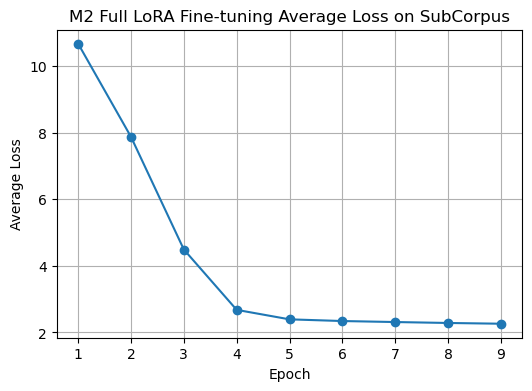

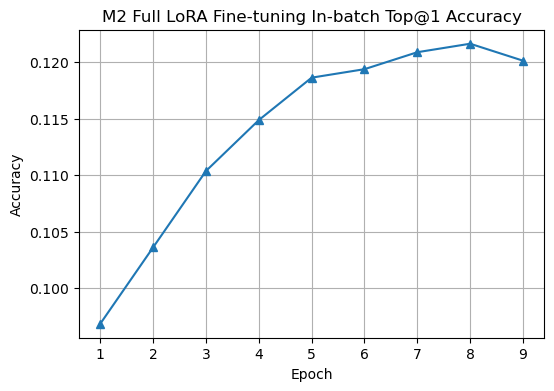

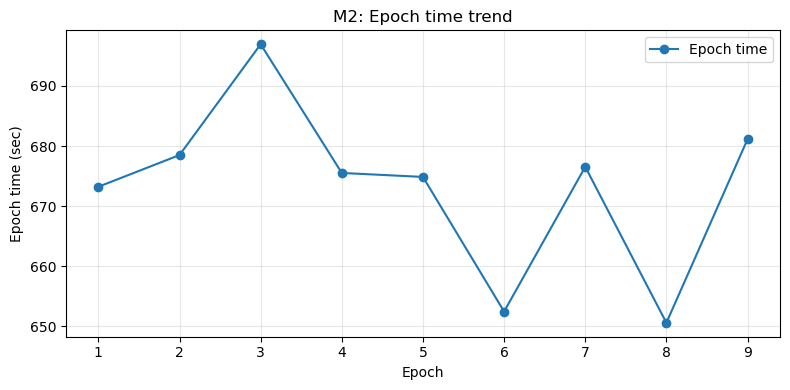


Best epoch: 3, Best full R@1: 0.0053


In [2]:
# Save results
epoch_m2_full = pd.DataFrame(epoch_logs)
display(epoch_m2_full)
csv_path = os.path.join(out_dir, "epoch_metrics_m2_full.csv")
epoch_m2_full.to_csv(csv_path, index = False)

# Training summary
best_full_r1 = (max(full_top1_list) if len(full_top1_list) else float('nan'))
summary_row = {
    "model_tag": "M2_LoRA_full",
    "device": device,
    "train_rows": train_set_size,
    "val_rows": val_set_size,
    "batch_size": 16,
    "epochs_run": epoch + 1,
    "best_epoch_full_R1": best_epoch,
    "best_full_R1": best_full_r1,
    "total_time_min": total_time / 60.0,
    "avg_epoch_time_sec": (np.mean([r["epoch_time_sec"] for r in epoch_logs]) if epoch_logs else float('nan')),
    "avg_throughput_sps": (np.mean([r["throughput_samples_per_sec"] for r in epoch_logs]) if epoch_logs else float('nan')),
    "trainable_params_M": trainable_params_after / 1e6,
    "total_params_M": total_params_after / 1e6,
}

# Print the training summary
print("\nModel 2 Training Summary:")
for k, v in summary_row.items():
    print(f"{k}: {v}")

# Visualise the LoRA fine-tuning average loss
plt.figure(figsize = (6, 4))
plt.plot(epoch_m2_full["epoch"], epoch_m2_full["avg_loss"], marker = "o", linestyle = "-")
plt.title("M2 Full LoRA Fine-tuning Average Loss on SubCorpus")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
loss_png = os.path.join(out_dir, "m2_full_training_loss.png")
plt.savefig(loss_png, dpi = 200)
plt.show()
plt.close()

# Visualise the in-batch Top@1 curve
plt.figure(figsize = (6, 4))
plt.plot(epoch_m2_full["epoch"], epoch_m2_full["inb_top1"], marker = "^", linestyle = "-")
plt.title("M2 Full LoRA Fine-tuning In-batch Top@1 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
acc_png = os.path.join(out_dir, "m2_full_inbatch_accuracy.png")
plt.savefig(acc_png, dpi = 200)
plt.show()
plt.close()

# Visualise epoch time trend
plt.figure(figsize = (8,4))
plt.plot(epoch_m2_full["epoch"], epoch_m2_full["epoch_time_sec"], marker = "o", linestyle = "-", label = "Epoch time")
plt.xlabel("Epoch")
plt.ylabel("Epoch time (sec)")
plt.title("M2: Epoch time trend")
plt.grid(True, alpha = 0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "epoch_time_trend_m2.png"), dpi = 150)
plt.show()
plt.close()

# Save the final model
final_dir = os.path.join(out_dir, "final_model")
os.makedirs(final_dir, exist_ok = True)
model.save_pretrained(final_dir)
processor.save_pretrained(final_dir)
print(f"\nBest epoch: {best_epoch}, Best full R@1: {best_full:.4f}")